## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [217]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P / https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /train-test-data.zip -d /

mkdir: cannot create directory ‘/data’: Permission denied
--2018-07-17 05:58:54--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.21.165
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.21.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘train-test-data.zip.6’

rain-test-data.zip. 100%[===================>] 322.93M  12.8MB/s    in 39s     

2018-07-17 05:59:35 (8.20 MB/s) - ‘train-test-data.zip.6’ saved [338613624/338613624]

unzip:  cannot find or open /train-test-data.zip, /train-test-data.zip.zip or /train-test-data.zip.ZIP.


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [218]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc1_drop): Dropout2d(p=0.4)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [220]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),RandomCrop(224),Normalize(),ToTensor()])

## testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [221]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/home/ec2-user/Util/data/training_frames_keypoints.csv',
                                             root_dir='/home/ec2-user/Util/data/training',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


In [222]:
import os
os.getcwd()

'/home/ec2-user/Data/Pytorch'

## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [223]:
## load training data in batches
# Try large 
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [224]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/home/ec2-user/Util/data/test_frames_keypoints.csv',
                                             root_dir='/home/ec2-user/Util/data/test/',
                                             transform=data_transform)



In [225]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [226]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        print(key_pts)
        
        # convert images to FloatTensors
        print(images)
        
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        print(output_pts)
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [227]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
#print(test_images.data.size())
#print(test_outputs.data.size())
#print(gt_pts.size())

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


tensor([[[-1.6900, -0.6500],
         [-1.6900, -0.3375],
         [-1.6275, -0.0250],
         ...,
         [ 0.2475,  0.4125],
         [ 0.1225,  0.4125],
         [ 0.0600,  0.4125]],

        [[-1.0900,  0.4750],
         [-1.0900,  0.7000],
         [-1.0150,  1.0000],
         ...,
         [ 0.2100,  1.4000],
         [ 0.1350,  1.4000],
         [-0.0150,  1.4000]],

        [[-1.0089,  0.5487],
         [-1.0089,  0.7570],
         [-0.8700,  1.1041],
         ...,
         [ 0.5883,  1.9372],
         [ 0.3800,  1.9372],
         [ 0.3106,  1.9372]],

        ...,

        [[-0.8332,  0.2296],
         [-0.8332,  0.3998],
         [-0.7195,  0.6835],
         ...,
         [ 0.3600,  1.2508],
         [ 0.2464,  1.2508],
         [ 0.1895,  1.2508]],

        [[-0.7466, -0.8609],
         [-0.8285, -0.5542],
         [-0.8285, -0.2476],
         ...,
         [ 0.3805,  0.5293],
         [ 0.2370,  0.5089],
         [ 0.0731,  0.5089]],

        [[-0.8974,  0.0020],
       

In [228]:
print(test_images[0].data)


tensor([[[ 0.3451,  0.3451,  0.3373,  ...,  0.7216,  0.7137,  0.7059],
         [ 0.3451,  0.3451,  0.3412,  ...,  0.7216,  0.7176,  0.7059],
         [ 0.3451,  0.3451,  0.3412,  ...,  0.7255,  0.7176,  0.7098],
         ...,
         [ 0.1373,  0.1373,  0.1333,  ...,  0.1176,  0.1176,  0.1451],
         [ 0.1373,  0.1373,  0.1373,  ...,  0.0902,  0.0667,  0.0784],
         [ 0.1412,  0.1412,  0.1412,  ...,  0.0902,  0.0627,  0.0706]]])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [230]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

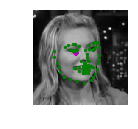

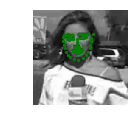

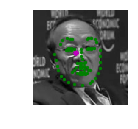

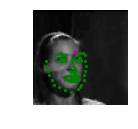

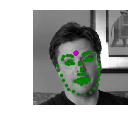

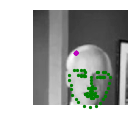

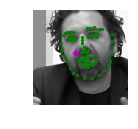

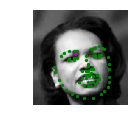

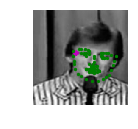

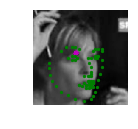

In [206]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        #print(test_images[i].shape)
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
        #print(image)
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        
        #print(predicted_key_pts)
        predicted_key_pts = predicted_key_pts*50.0+100
        #print(predicted_key_pts)
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [231]:
## TODO: Define the loss and optimization

import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.L1Loss()  ## works

#optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
optimizer = optim.Adam(net.parameters(),lr=0.001)
#optimizer = optim.Adagrad(net.parameters(),lr=0.01)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [232]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
         
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            #loss = criterion(output_pts, key_pts)
            loss = criterion(output_pts, key_pts)

    
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [ ]:
# train your network
n_epochs = 30# start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
#with active_session():
train_net(n_epochs)

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.036338977009058
Epoch: 1, Batch: 20, Avg. Loss: 0.0045460077226161955
Epoch: 1, Batch: 30, Avg. Loss: 0.003553783714771271
Epoch: 1, Batch: 40, Avg. Loss: 0.003166557639837265
Epoch: 1, Batch: 50, Avg. Loss: 0.003116928964853287
Epoch: 1, Batch: 60, Avg. Loss: 0.003059776782989502
Epoch: 1, Batch: 70, Avg. Loss: 0.0035707896649837495
Epoch: 1, Batch: 80, Avg. Loss: 0.00322710657119751
Epoch: 1, Batch: 90, Avg. Loss: 0.0029952073693275453
Epoch: 1, Batch: 100, Avg. Loss: 0.0034059091806411743
Epoch: 1, Batch: 110, Avg. Loss: 0.003136294990777969
Epoch: 1, Batch: 120, Avg. Loss: 0.0037153545171022414
Epoch: 1, Batch: 130, Avg. Loss: 0.003258626863360405
Epoch: 1, Batch: 140, Avg. Loss: 0.0033040300607681274
Epoch: 1, Batch: 150, Avg. Loss: 0.0029033740609884263
Epoch: 1, Batch: 160, Avg. Loss: 0.0035767486691474916
Epoch: 1, Batch: 170, Avg. Loss: 0.003691732496023178
Epoch: 1, Batch: 180, Avg. Loss: 0.0035036219954490662
Epoch: 1, Batch: 190, Avg. Loss:

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.003432526558637619
Epoch: 2, Batch: 20, Avg. Loss: 0.003203815042972565
Epoch: 2, Batch: 30, Avg. Loss: 0.0035426098704338074
Epoch: 2, Batch: 40, Avg. Loss: 0.003386691004037857
Epoch: 2, Batch: 50, Avg. Loss: 0.0033383390605449675
Epoch: 2, Batch: 60, Avg. Loss: 0.0031381770074367524
Epoch: 2, Batch: 70, Avg. Loss: 0.003149555593729019
Epoch: 2, Batch: 80, Avg. Loss: 0.003056085228919983
Epoch: 2, Batch: 90, Avg. Loss: 0.003047500401735306
Epoch: 2, Batch: 100, Avg. Loss: 0.00338301083445549
Epoch: 2, Batch: 110, Avg. Loss: 0.0033005844205617903
Epoch: 2, Batch: 120, Avg. Loss: 0.003387830317020416
Epoch: 2, Batch: 130, Avg. Loss: 0.003278571456670761
Epoch: 2, Batch: 140, Avg. Loss: 0.0034838373064994812
Epoch: 2, Batch: 150, Avg. Loss: 0.0032365894615650178
Epoch: 2, Batch: 160, Avg. Loss: 0.0033969478011131285
Epoch: 2, Batch: 170, Avg. Loss: 0.0034772838354110718
Epoch: 2, Batch: 180, Avg. Loss: 0.0031550089865922926
Epoch: 2, Batch: 190, Avg. Lo

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.003708974450826645
Epoch: 3, Batch: 20, Avg. Loss: 0.003299726486206055
Epoch: 3, Batch: 30, Avg. Loss: 0.003574323534965515
Epoch: 3, Batch: 40, Avg. Loss: 0.003347836971282959
Epoch: 3, Batch: 50, Avg. Loss: 0.003432617574930191
Epoch: 3, Batch: 60, Avg. Loss: 0.0032375295013189315
Epoch: 3, Batch: 70, Avg. Loss: 0.003263096138834953
Epoch: 3, Batch: 80, Avg. Loss: 0.0032511508464813234
Epoch: 3, Batch: 90, Avg. Loss: 0.0030808809101581574
Epoch: 3, Batch: 100, Avg. Loss: 0.003308637171983719
Epoch: 3, Batch: 110, Avg. Loss: 0.002948265850543976
Epoch: 3, Batch: 120, Avg. Loss: 0.0032912678420543673
Epoch: 3, Batch: 130, Avg. Loss: 0.002846059277653694
Epoch: 3, Batch: 140, Avg. Loss: 0.0031576625704765318
Epoch: 3, Batch: 150, Avg. Loss: 0.0036298043429851532
Epoch: 3, Batch: 160, Avg. Loss: 0.003299991026520729
Epoch: 3, Batch: 170, Avg. Loss: 0.0033460918068885805
Epoch: 3, Batch: 180, Avg. Loss: 0.0035514045655727386
Epoch: 3, Batch: 190, Avg. Lo

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.0032354963570833204
Epoch: 4, Batch: 20, Avg. Loss: 0.0032376835197210313
Epoch: 4, Batch: 30, Avg. Loss: 0.0032709677815437317
Epoch: 4, Batch: 40, Avg. Loss: 0.0029802636951208115
Epoch: 4, Batch: 50, Avg. Loss: 0.0034606980085372923
Epoch: 4, Batch: 60, Avg. Loss: 0.003303174465894699
Epoch: 4, Batch: 70, Avg. Loss: 0.0031744632124900817
Epoch: 4, Batch: 80, Avg. Loss: 0.003144996851682663
Epoch: 4, Batch: 90, Avg. Loss: 0.0030317164659500124
Epoch: 4, Batch: 100, Avg. Loss: 0.0031604430079460143
Epoch: 4, Batch: 110, Avg. Loss: 0.0034781993925571443
Epoch: 4, Batch: 120, Avg. Loss: 0.003224061369895935
Epoch: 4, Batch: 130, Avg. Loss: 0.003301308214664459
Epoch: 4, Batch: 140, Avg. Loss: 0.0032199312895536424
Epoch: 4, Batch: 150, Avg. Loss: 0.0031286764144897463
Epoch: 4, Batch: 160, Avg. Loss: 0.0032808134704828264
Epoch: 4, Batch: 170, Avg. Loss: 0.0034408925771713256
Epoch: 4, Batch: 180, Avg. Loss: 0.0032178435027599333
Epoch: 4, Batch: 190, A

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.003321505844593048
Epoch: 5, Batch: 20, Avg. Loss: 0.003102827772498131
Epoch: 5, Batch: 30, Avg. Loss: 0.0037770561873912813
Epoch: 5, Batch: 40, Avg. Loss: 0.0034677342474460603
Epoch: 5, Batch: 50, Avg. Loss: 0.0029049848318099974
Epoch: 5, Batch: 60, Avg. Loss: 0.003409059137105942
Epoch: 5, Batch: 70, Avg. Loss: 0.0031830559074878693
Epoch: 5, Batch: 80, Avg. Loss: 0.0032008100748062134
Epoch: 5, Batch: 90, Avg. Loss: 0.003191879227757454
Epoch: 5, Batch: 100, Avg. Loss: 0.003245179921388626
Epoch: 5, Batch: 110, Avg. Loss: 0.0032622611224651338
Epoch: 5, Batch: 120, Avg. Loss: 0.0033830630630254746
Epoch: 5, Batch: 130, Avg. Loss: 0.0032376789152622223
Epoch: 5, Batch: 140, Avg. Loss: 0.003467806935310364
Epoch: 5, Batch: 150, Avg. Loss: 0.0031194004267454147
Epoch: 5, Batch: 160, Avg. Loss: 0.0033450052440166475
Epoch: 5, Batch: 170, Avg. Loss: 0.0033930086195468902
Epoch: 5, Batch: 180, Avg. Loss: 0.003298702672123909
Epoch: 5, Batch: 190, Avg.

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.0032523799538612366
Epoch: 6, Batch: 20, Avg. Loss: 0.003287355124950409
Epoch: 6, Batch: 30, Avg. Loss: 0.0033837768435478212
Epoch: 6, Batch: 40, Avg. Loss: 0.003089036822319031
Epoch: 6, Batch: 50, Avg. Loss: 0.0034972243010997772
Epoch: 6, Batch: 60, Avg. Loss: 0.003175782933831215
Epoch: 6, Batch: 70, Avg. Loss: 0.0031593005061149597
Epoch: 6, Batch: 80, Avg. Loss: 0.0036496065557003023
Epoch: 6, Batch: 90, Avg. Loss: 0.0030010530054569245
Epoch: 6, Batch: 100, Avg. Loss: 0.002947226643562317
Epoch: 6, Batch: 110, Avg. Loss: 0.0032693776786327363
Epoch: 6, Batch: 120, Avg. Loss: 0.00306906533241272
Epoch: 6, Batch: 130, Avg. Loss: 0.0029884380996227262
Epoch: 6, Batch: 140, Avg. Loss: 0.0035875590145587923
Epoch: 6, Batch: 150, Avg. Loss: 0.003273177370429039
Epoch: 6, Batch: 160, Avg. Loss: 0.00338967490196228
Epoch: 6, Batch: 170, Avg. Loss: 0.0035876589715480803
Epoch: 6, Batch: 180, Avg. Loss: 0.0032027917206287385
Epoch: 6, Batch: 190, Avg. L

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.0034262835383415224
Epoch: 7, Batch: 20, Avg. Loss: 0.0031146552264690397
Epoch: 7, Batch: 30, Avg. Loss: 0.0031184165179729464
Epoch: 7, Batch: 40, Avg. Loss: 0.0031679382175207136
Epoch: 7, Batch: 50, Avg. Loss: 0.0031675879955291746
Epoch: 7, Batch: 60, Avg. Loss: 0.0033406142592430116
Epoch: 7, Batch: 70, Avg. Loss: 0.0032604412138462066
Epoch: 7, Batch: 80, Avg. Loss: 0.0034265349507331846
Epoch: 7, Batch: 90, Avg. Loss: 0.0033539344668388365
Epoch: 7, Batch: 100, Avg. Loss: 0.0034051376283168793
Epoch: 7, Batch: 110, Avg. Loss: 0.0032824242413043974
Epoch: 7, Batch: 120, Avg. Loss: 0.003494683921337128
Epoch: 11, Batch: 250, Avg. Loss: 0.0034263067543506623
Epoch: 11, Batch: 260, Avg. Loss: 0.0030550188422203066
Epoch: 11, Batch: 270, Avg. Loss: 0.003533148169517517
Epoch: 11, Batch: 280, Avg. Loss: 0.003551058292388916
Epoch: 11, Batch: 290, Avg. Loss: 0.0032611293494701384
Epoch: 11, Batch: 300, Avg. Loss: 0.003219289541244507
Epoch: 11, Batch:

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.0030802923291921615
Epoch: 12, Batch: 20, Avg. Loss: 0.003374904990196228
Epoch: 12, Batch: 30, Avg. Loss: 0.0034162479341030122
Epoch: 12, Batch: 40, Avg. Loss: 0.003251908153295517
Epoch: 12, Batch: 50, Avg. Loss: 0.0032841293513774872
Epoch: 12, Batch: 60, Avg. Loss: 0.0032565148174762727
Epoch: 12, Batch: 70, Avg. Loss: 0.003344215631484985
Epoch: 12, Batch: 80, Avg. Loss: 0.003279055029153824
Epoch: 12, Batch: 90, Avg. Loss: 0.003055286318063736
Epoch: 12, Batch: 100, Avg. Loss: 0.0031512966901063918
Epoch: 12, Batch: 110, Avg. Loss: 0.0033726520240306853
Epoch: 12, Batch: 120, Avg. Loss: 0.0029030983597040177
Epoch: 12, Batch: 130, Avg. Loss: 0.0031364541202783583
Epoch: 12, Batch: 140, Avg. Loss: 0.003269998162984848
Epoch: 12, Batch: 150, Avg. Loss: 0.0034393791258335114
Epoch: 12, Batch: 160, Avg. Loss: 0.003189768001437187
Epoch: 12, Batch: 170, Avg. Loss: 0.003338282823562622
Epoch: 12, Batch: 180, Avg. Loss: 0.0031698365956544876
Epoch: 12

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.0035203761905431745
Epoch: 13, Batch: 20, Avg. Loss: 0.003659340113401413
Epoch: 13, Batch: 30, Avg. Loss: 0.003431997925043106
Epoch: 13, Batch: 40, Avg. Loss: 0.0033745510280132293
Epoch: 13, Batch: 50, Avg. Loss: 0.003172014057636261
Epoch: 13, Batch: 60, Avg. Loss: 0.003445727303624153
Epoch: 13, Batch: 70, Avg. Loss: 0.003368003100156784
Epoch: 13, Batch: 80, Avg. Loss: 0.0030786467492580414
Epoch: 13, Batch: 90, Avg. Loss: 0.003150142580270767
Epoch: 13, Batch: 100, Avg. Loss: 0.0030340487957000732
Epoch: 13, Batch: 110, Avg. Loss: 0.0035099776685237885
Epoch: 13, Batch: 120, Avg. Loss: 0.0033810630440711973
Epoch: 13, Batch: 130, Avg. Loss: 0.0029850793182849885
Epoch: 13, Batch: 140, Avg. Loss: 0.0030682911574840548
Epoch: 13, Batch: 150, Avg. Loss: 0.003101628229022026
Epoch: 13, Batch: 160, Avg. Loss: 0.0035381149351596834
Epoch: 13, Batch: 170, Avg. Loss: 0.003287231504917145
Epoch: 13, Batch: 180, Avg. Loss: 0.0028940928429365157
Epoch: 13

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.0035932290852069854
Epoch: 14, Batch: 20, Avg. Loss: 0.003195489406585693
Epoch: 14, Batch: 30, Avg. Loss: 0.0032746502161026003
Epoch: 14, Batch: 40, Avg. Loss: 0.0032230594009160997
Epoch: 14, Batch: 50, Avg. Loss: 0.0029978868812322616
Epoch: 14, Batch: 60, Avg. Loss: 0.003068464830517769
Epoch: 14, Batch: 70, Avg. Loss: 0.00316473388671875
Epoch: 14, Batch: 80, Avg. Loss: 0.0031427333503961565
Epoch: 14, Batch: 90, Avg. Loss: 0.0033220399022102355
Epoch: 14, Batch: 100, Avg. Loss: 0.0037887685894966126
Epoch: 14, Batch: 110, Avg. Loss: 0.003504581719636917
Epoch: 14, Batch: 120, Avg. Loss: 0.0032256726026535032
Epoch: 14, Batch: 130, Avg. Loss: 0.003448568731546402
Epoch: 14, Batch: 140, Avg. Loss: 0.003301680415868759
Epoch: 14, Batch: 150, Avg. Loss: 0.0032857092171907423
Epoch: 14, Batch: 160, Avg. Loss: 0.0033089359402656555
Epoch: 14, Batch: 170, Avg. Loss: 0.0035538687109947205
Epoch: 14, Batch: 180, Avg. Loss: 0.0032174274623394013
Epoch: 1

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.003540840446949005
Epoch: 15, Batch: 20, Avg. Loss: 0.003299038887023926
Epoch: 15, Batch: 30, Avg. Loss: 0.0035167318284511566
Epoch: 15, Batch: 40, Avg. Loss: 0.003139828622341156
Epoch: 15, Batch: 50, Avg. Loss: 0.0032504721581935883
Epoch: 15, Batch: 60, Avg. Loss: 0.0035418918132781984
Epoch: 15, Batch: 70, Avg. Loss: 0.003536738336086273
Epoch: 15, Batch: 80, Avg. Loss: 0.0032435060441493987
Epoch: 15, Batch: 90, Avg. Loss: 0.00318921534717083
Epoch: 15, Batch: 100, Avg. Loss: 0.0030748683214187624
Epoch: 15, Batch: 110, Avg. Loss: 0.002902712270617485
Epoch: 15, Batch: 120, Avg. Loss: 0.003427075654268265
Epoch: 15, Batch: 130, Avg. Loss: 0.0034497995376586914
Epoch: 15, Batch: 140, Avg. Loss: 0.0034344542920589447
Epoch: 15, Batch: 150, Avg. Loss: 0.003645533084869385
Epoch: 15, Batch: 160, Avg. Loss: 0.003362895280122757
Epoch: 15, Batch: 170, Avg. Loss: 0.0033441837430000306
Epoch: 15, Batch: 180, Avg. Loss: 0.003000471815466881
Epoch: 15, B

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.0035734366774559023
Epoch: 16, Batch: 20, Avg. Loss: 0.0033044233322143553
Epoch: 16, Batch: 30, Avg. Loss: 0.0031257408410310743
Epoch: 16, Batch: 40, Avg. Loss: 0.0031386135816574095
Epoch: 16, Batch: 50, Avg. Loss: 0.0033264130651950836
Epoch: 16, Batch: 60, Avg. Loss: 0.0032239586114883425
Epoch: 16, Batch: 70, Avg. Loss: 0.003067162334918976
Epoch: 16, Batch: 80, Avg. Loss: 0.00298188491165638
Epoch: 16, Batch: 90, Avg. Loss: 0.0031881033629179
Epoch: 16, Batch: 100, Avg. Loss: 0.003260285347700119
Epoch: 16, Batch: 110, Avg. Loss: 0.0034214009642601012
Epoch: 16, Batch: 120, Avg. Loss: 0.003347693622112274
Epoch: 16, Batch: 130, Avg. Loss: 0.0035205891728401183
Epoch: 16, Batch: 140, Avg. Loss: 0.0033738642036914824
Epoch: 16, Batch: 150, Avg. Loss: 0.003434324711561203
Epoch: 16, Batch: 160, Avg. Loss: 0.0029336564987897874
Epoch: 16, Batch: 170, Avg. Loss: 0.003234518885612488
Epoch: 16, Batch: 180, Avg. Loss: 0.0033535660207271575
Epoch: 16, 

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.003449450194835663
Epoch: 17, Batch: 20, Avg. Loss: 0.003689985752105713
Epoch: 17, Batch: 30, Avg. Loss: 0.0033953378796577455
Epoch: 17, Batch: 40, Avg. Loss: 0.0032206574082374573
Epoch: 17, Batch: 50, Avg. Loss: 0.0034004769921302793
Epoch: 17, Batch: 60, Avg. Loss: 0.00347154638171196
Epoch: 17, Batch: 70, Avg. Loss: 0.0032277530431747436
Epoch: 17, Batch: 80, Avg. Loss: 0.003130442053079605
Epoch: 17, Batch: 90, Avg. Loss: 0.003309063896536827
Epoch: 17, Batch: 100, Avg. Loss: 0.003087952956557274
Epoch: 17, Batch: 110, Avg. Loss: 0.003298391580581665
Epoch: 17, Batch: 120, Avg. Loss: 0.00325626565515995
Epoch: 17, Batch: 130, Avg. Loss: 0.0033929791450500488
Epoch: 17, Batch: 140, Avg. Loss: 0.0036338436901569367
Epoch: 17, Batch: 150, Avg. Loss: 0.0032460002303123475
Epoch: 17, Batch: 160, Avg. Loss: 0.003506328046321869
Epoch: 17, Batch: 170, Avg. Loss: 0.0035468324422836305
Epoch: 17, Batch: 180, Avg. Loss: 0.0032106742262840273
Epoch: 17, B

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.0032216919362545015
Epoch: 18, Batch: 20, Avg. Loss: 0.0035907678455114364
Epoch: 18, Batch: 30, Avg. Loss: 0.0034784234762191774
Epoch: 18, Batch: 40, Avg. Loss: 0.0032840096354484556
Epoch: 18, Batch: 50, Avg. Loss: 0.0032412451803684236
Epoch: 18, Batch: 60, Avg. Loss: 0.003104410529136658
Epoch: 18, Batch: 70, Avg. Loss: 0.0033554307222366333
Epoch: 18, Batch: 80, Avg. Loss: 0.003125657483935356
Epoch: 18, Batch: 90, Avg. Loss: 0.0029306577742099762
Epoch: 18, Batch: 100, Avg. Loss: 0.0031231767982244493
Epoch: 18, Batch: 110, Avg. Loss: 0.0032362748086452483
Epoch: 18, Batch: 120, Avg. Loss: 0.0034889761805534363
Epoch: 18, Batch: 130, Avg. Loss: 0.003230803266167641
Epoch: 18, Batch: 140, Avg. Loss: 0.0031686549484729767
Epoch: 18, Batch: 150, Avg. Loss: 0.0033261684477329254
Epoch: 18, Batch: 160, Avg. Loss: 0.0032669094204902647
Epoch: 18, Batch: 170, Avg. Loss: 0.003475853353738785
Epoch: 18, Batch: 180, Avg. Loss: 0.003249039173126221
Epoch:

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.003558358281850815
Epoch: 19, Batch: 20, Avg. Loss: 0.0030301945507526396
Epoch: 19, Batch: 30, Avg. Loss: 0.0037013734579086303
Epoch: 19, Batch: 40, Avg. Loss: 0.0031188041269779206
Epoch: 19, Batch: 50, Avg. Loss: 0.003509752511978149
Epoch: 19, Batch: 60, Avg. Loss: 0.0030507914870977404
Epoch: 19, Batch: 70, Avg. Loss: 0.0031243875324726104
Epoch: 19, Batch: 80, Avg. Loss: 0.003152501180768013
Epoch: 19, Batch: 90, Avg. Loss: 0.002968174755573273
Epoch: 19, Batch: 100, Avg. Loss: 0.0032021408677101134
Epoch: 19, Batch: 110, Avg. Loss: 0.0030428663045167924
Epoch: 19, Batch: 120, Avg. Loss: 0.003494717285037041
Epoch: 19, Batch: 130, Avg. Loss: 0.003269846707582474
Epoch: 19, Batch: 140, Avg. Loss: 0.00345004016160965
Epoch: 19, Batch: 150, Avg. Loss: 0.0031842920631170273
Epoch: 19, Batch: 160, Avg. Loss: 0.0034497133791446684
Epoch: 19, Batch: 170, Avg. Loss: 0.003353547990322113
Epoch: 19, Batch: 180, Avg. Loss: 0.003291660964488983
Epoch: 19, 

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.0031726963073015215
Epoch: 20, Batch: 20, Avg. Loss: 0.003447931557893753
Epoch: 20, Batch: 30, Avg. Loss: 0.003043281942605972
Epoch: 20, Batch: 40, Avg. Loss: 0.003115946739912033
Epoch: 20, Batch: 50, Avg. Loss: 0.0031595759093761442
Epoch: 20, Batch: 60, Avg. Loss: 0.003038052499294281
Epoch: 20, Batch: 70, Avg. Loss: 0.003322814613580704
Epoch: 20, Batch: 80, Avg. Loss: 0.0033810960352420806
Epoch: 20, Batch: 90, Avg. Loss: 0.003162585824728012
Epoch: 20, Batch: 100, Avg. Loss: 0.003600472241640091
Epoch: 20, Batch: 110, Avg. Loss: 0.003358791261911392
Epoch: 20, Batch: 120, Avg. Loss: 0.0032616934925317766
Epoch: 20, Batch: 130, Avg. Loss: 0.003455611690878868
Epoch: 20, Batch: 140, Avg. Loss: 0.0035053945183753966
Epoch: 20, Batch: 150, Avg. Loss: 0.0029772605001926423
Epoch: 20, Batch: 160, Avg. Loss: 0.0032275822758674622
Epoch: 20, Batch: 170, Avg. Loss: 0.0032109528183937074
Epoch: 20, Batch: 180, Avg. Loss: 0.003284426346421242
Epoch: 20, 

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.0031266967952251435
Epoch: 21, Batch: 20, Avg. Loss: 0.0034778206944465636
Epoch: 21, Batch: 30, Avg. Loss: 0.003014594987034798
Epoch: 21, Batch: 40, Avg. Loss: 0.003186043232679367
Epoch: 21, Batch: 50, Avg. Loss: 0.003264633193612099
Epoch: 21, Batch: 60, Avg. Loss: 0.0031811966747045516
Epoch: 21, Batch: 70, Avg. Loss: 0.0033062758445739746
Epoch: 21, Batch: 80, Avg. Loss: 0.0035417210459709166
Epoch: 21, Batch: 90, Avg. Loss: 0.0030678308755159376
Epoch: 21, Batch: 100, Avg. Loss: 0.0035246819108724595
Epoch: 21, Batch: 110, Avg. Loss: 0.003117154687643051
Epoch: 21, Batch: 120, Avg. Loss: 0.0032537348568439485
Epoch: 21, Batch: 130, Avg. Loss: 0.003093251794576645
Epoch: 21, Batch: 140, Avg. Loss: 0.003458862334489822
Epoch: 21, Batch: 150, Avg. Loss: 0.003194045141339302
Epoch: 21, Batch: 160, Avg. Loss: 0.003253272980451584
Epoch: 21, Batch: 170, Avg. Loss: 0.0035694014132022856
Epoch: 21, Batch: 180, Avg. Loss: 0.003431791514158249
Epoch: 21,

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.0034412916004657747
Epoch: 22, Batch: 20, Avg. Loss: 0.003179564505815506
Epoch: 22, Batch: 30, Avg. Loss: 0.0030870331823825837
Epoch: 22, Batch: 40, Avg. Loss: 0.00314332714676857
Epoch: 22, Batch: 50, Avg. Loss: 0.0030969032794237136
Epoch: 22, Batch: 60, Avg. Loss: 0.003301681950688362
Epoch: 22, Batch: 70, Avg. Loss: 0.0035681350529193877
Epoch: 22, Batch: 80, Avg. Loss: 0.0032941010147333146
Epoch: 22, Batch: 90, Avg. Loss: 0.0031519005596637724
Epoch: 22, Batch: 100, Avg. Loss: 0.003209906280040741
Epoch: 22, Batch: 110, Avg. Loss: 0.0033214302361011506
Epoch: 22, Batch: 120, Avg. Loss: 0.002845925733447075
Epoch: 22, Batch: 130, Avg. Loss: 0.003473644584417343
Epoch: 22, Batch: 140, Avg. Loss: 0.00332842230796814
Epoch: 22, Batch: 150, Avg. Loss: 0.003411117672920227
Epoch: 22, Batch: 160, Avg. Loss: 0.003562610685825348
Epoch: 22, Batch: 170, Avg. Loss: 0.0036467577815055847
Epoch: 22, Batch: 180, Avg. Loss: 0.0030672116577625274
Epoch: 22, B

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.0035416525155305863
Epoch: 23, Batch: 20, Avg. Loss: 0.003362134248018265
Epoch: 23, Batch: 30, Avg. Loss: 0.0032229285240173338
Epoch: 23, Batch: 40, Avg. Loss: 0.0030894824713468554
Epoch: 23, Batch: 50, Avg. Loss: 0.003133038341999054
Epoch: 23, Batch: 60, Avg. Loss: 0.0034331617653369905
Epoch: 23, Batch: 70, Avg. Loss: 0.0033836761713027953
Epoch: 23, Batch: 80, Avg. Loss: 0.0034459061026573183
Epoch: 23, Batch: 90, Avg. Loss: 0.0030772667676210405
Epoch: 23, Batch: 100, Avg. Loss: 0.0031256265342235567
Epoch: 23, Batch: 110, Avg. Loss: 0.003303020417690277
Epoch: 23, Batch: 120, Avg. Loss: 0.0031528484672307968
Epoch: 23, Batch: 130, Avg. Loss: 0.003443058356642723
Epoch: 23, Batch: 140, Avg. Loss: 0.0032227268517017365
Epoch: 23, Batch: 150, Avg. Loss: 0.0031447431594133378
Epoch: 23, Batch: 160, Avg. Loss: 0.0033067297637462616
Epoch: 23, Batch: 170, Avg. Loss: 0.003248919978737831
Epoch: 23, Batch: 180, Avg. Loss: 0.003194834738969803
Epoch: 

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.003233055144548416
Epoch: 24, Batch: 20, Avg. Loss: 0.0031190663129091263
Epoch: 24, Batch: 30, Avg. Loss: 0.003278364270925522
Epoch: 24, Batch: 40, Avg. Loss: 0.0029680361449718477
Epoch: 24, Batch: 50, Avg. Loss: 0.003266449823975563
Epoch: 24, Batch: 60, Avg. Loss: 0.003528416931629181
Epoch: 24, Batch: 70, Avg. Loss: 0.0033448916971683504
Epoch: 24, Batch: 80, Avg. Loss: 0.003284519910812378
Epoch: 24, Batch: 90, Avg. Loss: 0.0029011476933956146
Epoch: 24, Batch: 100, Avg. Loss: 0.0031913858950138093
Epoch: 24, Batch: 110, Avg. Loss: 0.003155238747596741
Epoch: 24, Batch: 120, Avg. Loss: 0.003511535793542862
Epoch: 24, Batch: 130, Avg. Loss: 0.0030917016863822935
Epoch: 24, Batch: 140, Avg. Loss: 0.003010931730270386
Epoch: 24, Batch: 150, Avg. Loss: 0.0033730415999889372
Epoch: 24, Batch: 160, Avg. Loss: 0.0033475337624549865
Epoch: 24, Batch: 170, Avg. Loss: 0.00347208297252655
Epoch: 24, Batch: 180, Avg. Loss: 0.0031513110399246217
Epoch: 24, 

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.0035097533762454987
Epoch: 25, Batch: 20, Avg. Loss: 0.0033401452004909516
Epoch: 25, Batch: 30, Avg. Loss: 0.0033452546298503878
Epoch: 25, Batch: 40, Avg. Loss: 0.003237794131040573
Epoch: 25, Batch: 50, Avg. Loss: 0.0033599335253238676
Epoch: 25, Batch: 60, Avg. Loss: 0.0033375219851732255
Epoch: 25, Batch: 70, Avg. Loss: 0.0034197781383991242
Epoch: 25, Batch: 80, Avg. Loss: 0.003473554313182831
Epoch: 25, Batch: 90, Avg. Loss: 0.0028596626222133635
Epoch: 25, Batch: 100, Avg. Loss: 0.00354299196600914
Epoch: 25, Batch: 110, Avg. Loss: 0.0034164658337831498
Epoch: 25, Batch: 120, Avg. Loss: 0.002951962947845459
Epoch: 25, Batch: 130, Avg. Loss: 0.0036096298694610596
Epoch: 25, Batch: 140, Avg. Loss: 0.003311249554157257
Epoch: 25, Batch: 150, Avg. Loss: 0.0031087675392627717
Epoch: 25, Batch: 160, Avg. Loss: 0.0030762534141540528
Epoch: 25, Batch: 170, Avg. Loss: 0.0033876887261867525
Epoch: 25, Batch: 180, Avg. Loss: 0.003305141657590866
Epoch: 2

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.003449837699532509
Epoch: 26, Batch: 20, Avg. Loss: 0.003192407414317131
Epoch: 26, Batch: 30, Avg. Loss: 0.0034896366000175478
Epoch: 26, Batch: 40, Avg. Loss: 0.0030733079910278322
Epoch: 26, Batch: 50, Avg. Loss: 0.0029300164431333544
Epoch: 26, Batch: 60, Avg. Loss: 0.0031108874082565307
Epoch: 26, Batch: 70, Avg. Loss: 0.0032986954152584074
Epoch: 26, Batch: 80, Avg. Loss: 0.003296021580696106
Epoch: 26, Batch: 90, Avg. Loss: 0.00309785395860672
Epoch: 26, Batch: 100, Avg. Loss: 0.0031509033143520353
Epoch: 26, Batch: 110, Avg. Loss: 0.0030212093740701676
Epoch: 26, Batch: 120, Avg. Loss: 0.003841822385787964
Epoch: 26, Batch: 130, Avg. Loss: 0.0034014331996440887
Epoch: 26, Batch: 140, Avg. Loss: 0.0034573781192302703
Epoch: 26, Batch: 150, Avg. Loss: 0.003332754373550415
Epoch: 26, Batch: 160, Avg. Loss: 0.0035857256948947907
Epoch: 26, Batch: 170, Avg. Loss: 0.0035778512656688692
Epoch: 26, Batch: 180, Avg. Loss: 0.003120709180831909
Epoch: 26

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.003113843634724617
Epoch: 27, Batch: 20, Avg. Loss: 0.00326078362762928
Epoch: 27, Batch: 30, Avg. Loss: 0.0032096146792173386
Epoch: 27, Batch: 40, Avg. Loss: 0.0031095181405544283
Epoch: 27, Batch: 50, Avg. Loss: 0.003562040627002716
Epoch: 27, Batch: 60, Avg. Loss: 0.003148581564426422
Epoch: 27, Batch: 70, Avg. Loss: 0.00298724664747715
Epoch: 27, Batch: 80, Avg. Loss: 0.00331482869386673
Epoch: 27, Batch: 90, Avg. Loss: 0.0032776122838258743
Epoch: 27, Batch: 100, Avg. Loss: 0.003315141499042511
Epoch: 27, Batch: 110, Avg. Loss: 0.0029911143183708193
Epoch: 27, Batch: 120, Avg. Loss: 0.003165416419506073
Epoch: 27, Batch: 130, Avg. Loss: 0.003110684156417847
Epoch: 27, Batch: 140, Avg. Loss: 0.0032616792023181917
Epoch: 27, Batch: 150, Avg. Loss: 0.0034740309715270996
Epoch: 27, Batch: 160, Avg. Loss: 0.0035461226999759675
Epoch: 27, Batch: 170, Avg. Loss: 0.0034009535312652587
Epoch: 27, Batch: 180, Avg. Loss: 0.0030912640392780303
Epoch: 27, Ba

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.00320277413725853
Epoch: 28, Batch: 20, Avg. Loss: 0.0032928500771522524
Epoch: 28, Batch: 30, Avg. Loss: 0.0034888561218976975
Epoch: 28, Batch: 40, Avg. Loss: 0.0035636081099510194
Epoch: 28, Batch: 50, Avg. Loss: 0.0033227229416370394
Epoch: 28, Batch: 60, Avg. Loss: 0.0031950640231370926
Epoch: 28, Batch: 70, Avg. Loss: 0.002887116461992264
Epoch: 28, Batch: 80, Avg. Loss: 0.0030651030987501144
Epoch: 28, Batch: 90, Avg. Loss: 0.0030503326207399367
Epoch: 28, Batch: 100, Avg. Loss: 0.003221356928348541
Epoch: 28, Batch: 110, Avg. Loss: 0.0033254396915435793
Epoch: 28, Batch: 120, Avg. Loss: 0.003428318724036217
Epoch: 28, Batch: 130, Avg. Loss: 0.0030407461225986482
Epoch: 28, Batch: 140, Avg. Loss: 0.0031235821545124052
Epoch: 28, Batch: 150, Avg. Loss: 0.003341429978609085
Epoch: 28, Batch: 160, Avg. Loss: 0.0031338862329721453
Epoch: 28, Batch: 170, Avg. Loss: 0.0032870111167430877
Epoch: 28, Batch: 180, Avg. Loss: 0.003180668205022812
Epoch: 2

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.0032698528170585633
Epoch: 29, Batch: 20, Avg. Loss: 0.0033233731389045716
Epoch: 29, Batch: 30, Avg. Loss: 0.0032025124430656434
Epoch: 29, Batch: 40, Avg. Loss: 0.0030710141062736513
Epoch: 29, Batch: 50, Avg. Loss: 0.0031123529374599457
Epoch: 29, Batch: 60, Avg. Loss: 0.003266740292310715
Epoch: 29, Batch: 70, Avg. Loss: 0.0031947009563446046
Epoch: 29, Batch: 80, Avg. Loss: 0.0031837906390428544
Epoch: 29, Batch: 90, Avg. Loss: 0.003098370134830475
Epoch: 29, Batch: 100, Avg. Loss: 0.003577474594116211
Epoch: 29, Batch: 110, Avg. Loss: 0.0031758447885513307
Epoch: 29, Batch: 120, Avg. Loss: 0.003337668389081955
Epoch: 29, Batch: 130, Avg. Loss: 0.003223552346229553
Epoch: 29, Batch: 140, Avg. Loss: 0.0034200702607631683
Epoch: 29, Batch: 150, Avg. Loss: 0.0032678541243076325
Epoch: 29, Batch: 160, Avg. Loss: 0.003208060711622238
Epoch: 29, Batch: 170, Avg. Loss: 0.0034626524448394774
Epoch: 29, Batch: 180, Avg. Loss: 0.0033763176500797272
Epoch: 

/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ec2-user/Data/Pytorch/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.0033632382452487945
Epoch: 30, Batch: 20, Avg. Loss: 0.003205722242593765
Epoch: 30, Batch: 30, Avg. Loss: 0.0029823036938905717
Epoch: 30, Batch: 40, Avg. Loss: 0.0032279549837112426
Epoch: 30, Batch: 50, Avg. Loss: 0.0031558732092380522
Epoch: 30, Batch: 60, Avg. Loss: 0.0031587333977222444
Epoch: 30, Batch: 70, Avg. Loss: 0.003128465473651886
Epoch: 30, Batch: 80, Avg. Loss: 0.002867681160569191
Epoch: 30, Batch: 90, Avg. Loss: 0.0035450336635112763
Epoch: 30, Batch: 100, Avg. Loss: 0.0033545804023742674
Epoch: 30, Batch: 110, Avg. Loss: 0.003594544142484665
Epoch: 30, Batch: 120, Avg. Loss: 0.003332353264093399
Epoch: 30, Batch: 130, Avg. Loss: 0.003133152484893799
Epoch: 30, Batch: 140, Avg. Loss: 0.0033948222100734712
Epoch: 30, Batch: 150, Avg. Loss: 0.003396906167268753
Epoch: 30, Batch: 160, Avg. Loss: 0.003196740344166756
Epoch: 30, Batch: 170, Avg. Loss: 0.004001083463430405
Epoch: 30, Batch: 180, Avg. Loss: 0.002935867875814438
Epoch: 30, 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [ ]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images[0])
#print(test_outputs.data.size())
#print(gt_pts.size())

In [ ]:
#print(test_outputs)
import numpy
numpy.set_printoptions(threshold=numpy.nan)
#print(test_images[0])
print(test_images[0].min())

In [ ]:
total = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
# to convert `correct` from a Tensor into a scalar, use .item()
accuracy = 100.0 * correct.item() / total

# print it out!
print('Accuracy before training: ', accuracy)

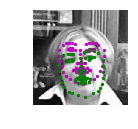

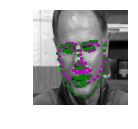

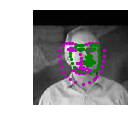

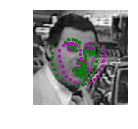

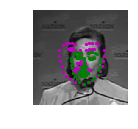

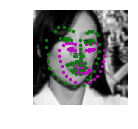

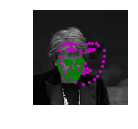

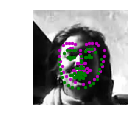

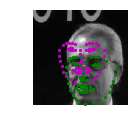

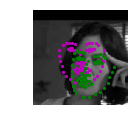

In [213]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [235]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_3_30epoch.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: Used Adaptive method like Adam for faster convergence and used L1 loss function for this regression problem to extract features in the convolutional layer

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: Earlier started with 2 convolutional layer than added 3 more and make the architecture similar to AlexNet which resulted in more features being extracted and better accuracy. Also adding dropout helped to reduce loss.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Used small batch of 10, as increasing batches result in loss in accuracy of the model, Used around 10 epoch to get satisfactory results

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [86]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


[[-0.02889366  0.05336358 -0.01371707 -0.04087728 -0.0349316   0.05017106
   0.00943975  0.04674868  0.07366522  0.03558876 -0.03070361]
 [-0.01133249 -0.06052106  0.03920291  0.02094483  0.0804946   0.0277574
  -0.02276179  0.05620953 -0.00997119  0.08332071  0.0005056 ]
 [ 0.02073159 -0.08269428 -0.01057509  0.0609508  -0.0680268   0.06326108
   0.04570828  0.03789388  0.03107281  0.063596   -0.07746357]
 [ 0.0394873  -0.08775679 -0.0401077   0.08404352  0.02009945  0.04802559
   0.001688   -0.06076164 -0.04185892 -0.07549469  0.00820399]
 [ 0.0898319   0.04064602 -0.03625971  0.07378301 -0.03573881 -0.08215239
  -0.01666991  0.02829595 -0.06946272  0.06827842  0.04852673]
 [-0.01458676  0.04096861 -0.04889099 -0.08197691 -0.01550493 -0.00675865
   0.00993586 -0.08030033 -0.01166525  0.02011441 -0.00947025]
 [-0.05400463  0.04068565  0.03457808  0.01820611 -0.0719552   0.08084056
   0.0082241   0.06014508 -0.05753996 -0.06903523 -0.04048986]
 [-0.00389545 -0.05542875 -0.08414777  0.0

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
test_images[0]

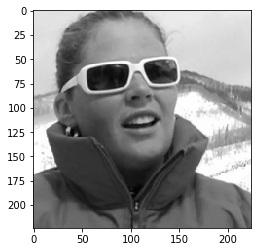

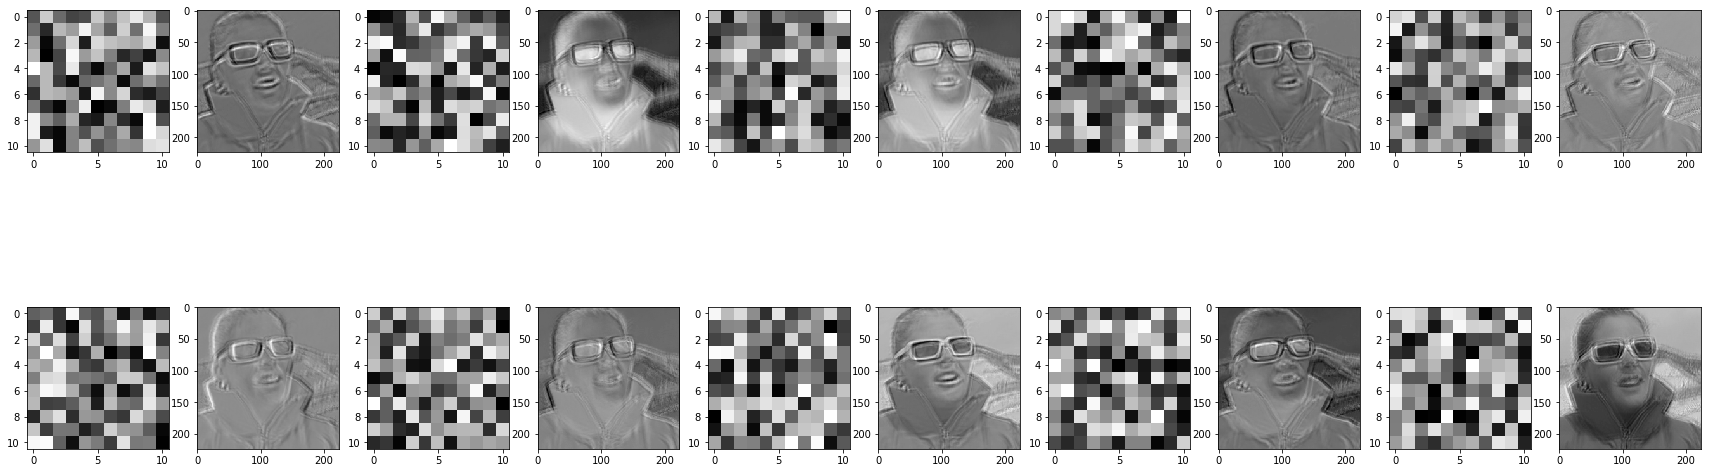

In [87]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

import cv2
import matplotlib.pyplot as plt

#dataiter = iter(test_loader)
#images, labels = dataiter.next()
images = test_images[0].numpy()

# select an image by index
#idx = 3
#img = np.squeeze(images[idx])
img = test_images[0].numpy().squeeze()



plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w = weights.numpy()


# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()



### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: The first filter on the top left of first row is an edge detection filter and detects the edges in the images
The second filter from left on top row is a blur filter which blurs the images and reduces the noise in the image


---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!